In [1]:
%load_ext autoreload
%autoreload 2

import logging
logging.basicConfig(level=logging.DEBUG)

In [2]:
import yass
from yass.neuralnet import NeuralNetDetector
from yass.augmentedSpikes import AugmentedSpikes

In [3]:
import os
import numpy as np
import tensorflow as tf
import progressbar
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 10)

In [4]:
from yass.preprocess.geometry import order_channels_by_distance, n_steps_neigh_channels

In [5]:
cfg = yass.Config.from_yaml('configuration_eduardo.yaml')

In [6]:
import scipy.io
kk = scipy.io.loadmat(os.path.join(cfg.root, 'groundtruth_ej49_data1_set1.mat'))
L_gt = kk['L_gt']-1
spt_gt = kk['spt_gt']
spt = np.concatenate((L_gt, spt_gt),axis=1)
idx_keep = np.logical_and(spt[:,1] > 80,spt[:,1]< 5*60*20000-80)
spt = spt[idx_keep]
asp = AugmentedSpikes(cfg,spt)

In [7]:
asp.config.spikeSize

15

In [8]:
R = asp.config.spikeSize
D = 3
k_idx = np.arange(49)
min_amp = 4
nspikes = 50000

In [ ]:
# get templates with big temporal size and align
templatesBig = asp.getBigTemplates(4*R)
templatesBig = templatesBig[k_idx]
k_idx2 = np.max(np.max(templatesBig,axis=1),axis=1) > 4
templatesBig = templatesBig[k_idx2]
K = templatesBig.shape[0]

templatesBig2, geom, neighChannels = asp.crop_templates(templatesBig,R,D+1)

amps = np.max(np.abs(templatesBig2),axis=1)
mainc = amps > np.expand_dims(np.max(amps,axis=1)*0.8,-1)

# make clean augmented spikes
nk = int(np.ceil(nspikes/K))
max_amp = np.max(amps)*1.5

In [ ]:
neighChannels = asp.config.neighChannels
geom = asp.config.geom
nneigh = np.max(np.sum(neighChannels, 0))

In [ ]:
x_clean = np.zeros((nk*K,templatesBig2.shape[1],templatesBig2.shape[2]))
for k in range(K):
    tt  = templatesBig2[k]    
    amp_now = np.max(np.abs(tt))
    amps_range = (np.arange(nk)*(max_amp-min_amp)/nk+min_amp)[:,np.newaxis,np.newaxis]                    
    x_clean[k*nk:(k+1)*nk] = (tt/amp_now)[np.newaxis,:,:]*amps_range
x_clean = x_clean[:,:,:nneigh]

#y_clean = np.zeros((nk*K,templatesBig2.shape[1]))
#mid_point = (x_clean.shape[1]-1)/2
#y_clean[:,mid_point] = 1

In [ ]:
# collision
x_collision = np.zeros(x_clean.shape)
max_shift = 2*R

temporal_shifts = np.random.randint(max_shift*2, size = nk*K) - max_shift
temporal_shifts[temporal_shifts<0] = temporal_shifts[temporal_shifts<0]-5
temporal_shifts[temporal_shifts>=0] = temporal_shifts[temporal_shifts>=0]+5

amp_per_data = np.max(x_clean[:,:,0],axis=1)
#random_match = np.random.randint(nk*K, size = nk*K)

mid_point = (x_clean.shape[1]-1)/2

for j in range(nk*K):
    shift = temporal_shifts[j]
    
    x_collision[j] = np.copy(x_clean[j])
    idx_candidate = np.where(np.logical_and(amp_per_data > amp_per_data[j]*0.5, amp_per_data < amp_per_data[j]*2))[0]
    idx_match = idx_candidate[np.random.randint(idx_candidate.shape[0], size = 1)[0]]
    #idx_match = random_match[j]
    x_clean2 = np.copy(x_clean[idx_match][:,np.random.choice(nneigh, nneigh, replace=False)])

    if shift > 0:
        x_collision[j,:(x_collision.shape[1]-shift)] += x_clean2[shift:]

    elif shift < 0:
        x_collision[j,(-shift):] += x_clean2[:(x_collision.shape[1]+shift)]
    else:
        x_collision[j] += x_clean2

# collision
x_collision2 = np.zeros(x_clean.shape)
max_shift = 2*R

temporal_shifts = np.random.randint(max_shift*2, size = nk*K) - max_shift
temporal_shifts[temporal_shifts<0] = temporal_shifts[temporal_shifts<0]-5
temporal_shifts[temporal_shifts>=0] = temporal_shifts[temporal_shifts>=0]+6

mid_point = (x_clean.shape[1]-1)/2

for j in range(nk*K):
    shift = temporal_shifts[j]
    x_clean2 = np.copy(x_clean[j][:,np.random.choice(nneigh, nneigh, replace=False)])

    if shift > 0:
        x_collision2[j,:(x_collision.shape[1]-shift)] += x_clean2[shift:]

    elif shift < 0:
        x_collision2[j,(-shift):] += x_clean2[:(x_collision.shape[1]+shift)]
    else:
        x_collision2[j] += x_clean2

        
x_collision3 = np.zeros(x_clean.shape)
max_shift = 2*R

temporal_shifts = np.random.randint(max_shift*2, size = nk*K) - max_shift
temporal_shifts[temporal_shifts<0] = temporal_shifts[temporal_shifts<0]-5
temporal_shifts[temporal_shifts>=0] = temporal_shifts[temporal_shifts>=0]+5

amp_per_data = np.max(x_clean[:,:,0],axis=1)
#random_match = np.random.randint(nk*K, size = nk*K)

mid_point = (x_clean.shape[1]-1)/2

for j in range(nk*K):
    shift = temporal_shifts[j]
    
    x_collision3[j] = np.copy(x_clean[j])
    idx_candidate = np.where(np.logical_and(amp_per_data > amp_per_data[j]*0.5, amp_per_data < amp_per_data[j]*2))[0]
    idx_match = idx_candidate[np.random.randint(idx_candidate.shape[0], size = 1)[0]]
    #idx_match = random_match[j]
    x_clean2 = np.copy(x_clean[idx_match])

    if shift > 0:
        x_collision3[j,:(x_collision.shape[1]-shift)] += x_clean2[shift:]

    elif shift < 0:
        x_collision3[j,(-shift):] += x_clean2[:(x_collision.shape[1]+shift)]
    else:
        x_collision3[j] += x_clean2
        
        
spatial_SIG, temporal_SIG = asp.determineNoiseCov(x_clean.shape[1],1)

In [ ]:
x_clean.shape

In [19]:
temporal_SIG

array([[ 0.71915676,  0.51451343,  0.30734923, ...,  0.00711517,
         0.01168001,  0.01117155],
       [ 0.51451343,  0.57738104,  0.47841914, ...,  0.00696489,
         0.00832074,  0.0098516 ],
       [ 0.30734923,  0.47841914,  0.5505434 , ...,  0.00546368,
         0.00613936,  0.00625904],
       ..., 
       [ 0.00711517,  0.00696489,  0.00546368, ...,  0.53747207,
         0.46064057,  0.2905726 ],
       [ 0.01168001,  0.00832074,  0.00613936, ...,  0.46064057,
         0.56174243,  0.5007136 ],
       [ 0.01117155,  0.0098516 ,  0.00625904, ...,  0.2905726 ,
         0.5007136 ,  0.70785593]])

In [20]:
def plot_matrix(m):
    plt.imshow(m)
    plt.colorbar()
    plt.show()

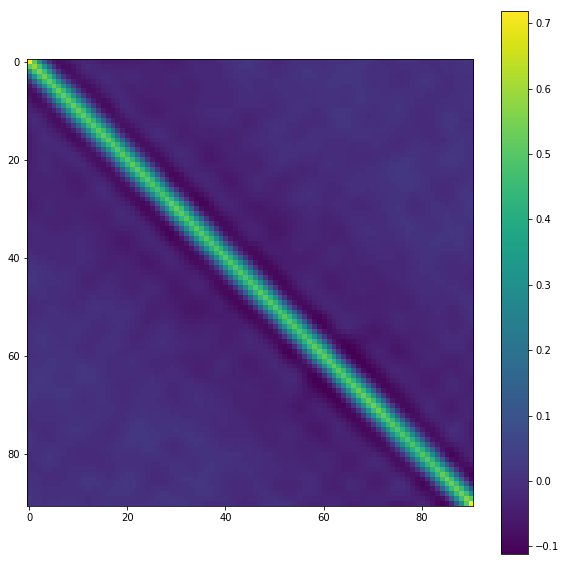

In [21]:
plot_matrix(temporal_SIG)

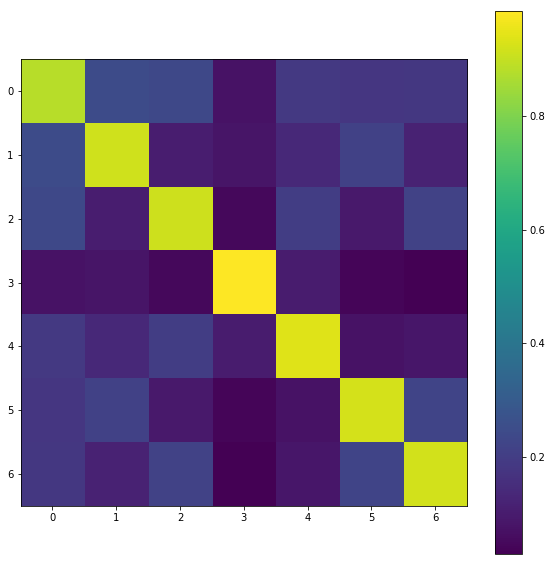

In [22]:
plot_matrix(spatial_SIG)

In [33]:
noise.dtype

dtype('float64')

In [23]:
x_clean.shape

(49998, 91, 7)

In [24]:
# get noise
noise = np.random.normal(size=x_clean.shape)
for c in range(noise.shape[2]):
    noise[:,:,c] = np.matmul(noise[:,:,c],temporal_SIG)

    reshaped_noise = np.reshape(noise,(-1,noise.shape[2]))
noise = np.reshape(np.matmul(reshaped_noise,spatial_SIG),[x_clean.shape[0],x_clean.shape[1],x_clean.shape[2]])

#y_clean = np.zeros((x_clean.shape[0],3))
#y_clean[:,1] = 1

#y_col = np.zeros((x_clean.shape[0],3))
#y_col[:,2] = 1

#y_noise = np.zeros((x_clean.shape[0],3))
#y_noise[:,0] = 1

y_clean = np.ones((x_clean.shape[0]))
y_col = np.ones((x_clean.shape[0]))
y_col2 = np.zeros((x_clean.shape[0]))
y_col3 = np.ones((x_clean.shape[0]))
y_noise = np.zeros((x_clean.shape[0]))

In [32]:
noise.shape

(49998, 91, 7)

In [31]:
noise.tofile('noise.bin')

In [17]:
x = np.concatenate( (
        x_clean + noise, 
        x_collision + noise[np.random.permutation(noise.shape[0])], 
        x_collision2 + noise[np.random.permutation(noise.shape[0])],
        x_collision3 + noise[np.random.permutation(noise.shape[0])],
        noise
    ) )
x = x[:,(mid_point-R):(mid_point+R+1),:]
y = np.concatenate( (y_clean, y_col, y_col2, y_col3, y_noise) )

# import scipy.io
# wf_test = scipy.io.loadmat('/ssd/data/peter/YASS/test/wf_test.mat')['wf_test']

# x_train = x
# y_train = y

In [18]:
noise.shape

(49998, 91, 7)

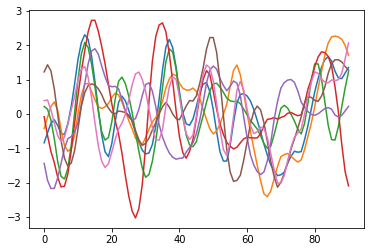

In [19]:
plt.plot(noise[10])

In [ ]:
plt.plot(noise[0].shape)

In [ ]:
nnd = NeuralNetDetector(cfg)
ndata, T, C = x_train.shape
R1 = 31
R2 = 5
nneigh = 7

ncells = [16, 8]
nn_name='detectnet1.ckpt'

nbatch = 512
niter = 5000

# Ndata, Time, Channels (7)    
x_tf = tf.placeholder("float", [None, None, None])
y_tf = tf.placeholder("float", [None])

W1 = nnd.weight_variable([R1,1,1,ncells[0]])
b1 = nnd.bias_variable([ncells[0]])
layer1 = tf.nn.relu(tf.nn.conv2d(tf.expand_dims(x_tf,-1), W1, strides=[1,1,1,1], padding='VALID')+b1)

W11 = nnd.weight_variable([1,1,ncells[0],ncells[1]])
b11 = nnd.bias_variable([ncells[1]])
layer11 = tf.nn.relu(tf.nn.conv2d(layer1, W11, strides=[1,1,1,1], padding='SAME')+b11)

W2 = nnd.weight_variable([1,nneigh,ncells[1],1])
b2 = nnd.bias_variable([1])
o_layer = tf.squeeze(tf.nn.conv2d(layer11, W2, strides=[1,1,1,1], padding='VALID')+b2)

layer1_test = tf.nn.relu(tf.nn.conv2d(tf.expand_dims(x_tf,-1), W1, strides=[1,1,1,1], padding='SAME')+b1)
layer11_test = tf.nn.relu(tf.nn.conv2d(layer1_test, W11, strides=[1,1,1,1], padding='SAME')+b11)
o_layer_test = tf.squeeze(tf.nn.conv2d(layer11_test, W2, strides=[1,1,1,1], padding='VALID')+b2)

#tf_prob = tf.nn.softmax(o_layer)
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_tf, logits=o_layer))

tf_prob = tf.sigmoid(o_layer)
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=o_layer, labels=y_tf))

TrainStepSize = nnd.config.neural_network['nnTrainStepSize']
TrainStepSize = 0.001
#train_step = tf.train.AdamOptimizer(TrainStepSize).minimize(cross_entropy)
weights = tf.trainable_variables()
l2_penalty = nnd.config.neural_network['nnL2RegScale']
l2_penalty = 1.5e-4
l2_regularizer = tf.contrib.layers.l2_regularizer(
            scale=l2_penalty)
regularization_penalty = tf.contrib.layers.apply_regularization(l2_regularizer, weights)
regularized_loss = cross_entropy + regularization_penalty
train_step = tf.train.AdamOptimizer(TrainStepSize).minimize(regularized_loss)

saver_triagenet = tf.train.Saver({"W1": W1,"W2": W2,"W11":W11,"b11":b11,"b1": b1,"b2": b2})

In [ ]:
bar = progressbar.ProgressBar(maxval=niter)
with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)

    for i in range(0, niter):
        idx_batch = np.random.choice(ndata, nbatch, replace=False)
        
        x_output, y_output = (x_train[idx_batch], y_train[idx_batch])
        
        if np.mod(i, 500) == 0:
            pp = sess.run(tf_prob, feed_dict={x_tf: x_output})
            ll = sess.run(cross_entropy, feed_dict={x_tf: x_output, y_tf: y_output})
            rl = sess.run(regularization_penalty, feed_dict={x_tf: x_output, y_tf: y_output})
            print(ll,rl)
            idx_pos = (y_output).astype('bool')
            #0.7 0.3
            print(np.mean(pp[idx_pos] > 0.9),np.sum(pp[~idx_pos] > 0.1))
            #est_label = np.argmax(pp,axis=1)
            #true_label = np.argmax(y_output, axis=1)
            #print(np.mean(est_label[true_label==0]==0),np.mean(est_label[true_label==1]==1),np.mean(est_label[true_label==2]==2))
            #pp_test = sess.run(tf_prob, feed_dict={x_tf: wf_test[:,:,[0]]})
            #print(np.mean(np.max(pp_test,axis=1) > 0.5))

            pp_test=np.zeros([wf_test.shape[0],wf_test.shape[1]])
            ntest =wf_test.shape[0]
            for i in range(ntest/100):
                pp_test[100*i:100*(i+1)]= sess.run(o_layer_test, feed_dict={x_tf: wf_test[100*i:100*(i+1)]})

            pp_test[(ntest/100)*100:ntest] = sess.run(o_layer_test, feed_dict={x_tf: wf_test[(ntest/100)*100:ntest]})
            print(np.mean(np.max(pp_test[:,40:60],axis=1) > 0))
            
            saver_triagenet.save(sess, os.path.join(nnd.config.root, nn_name))

        sess.run(train_step, feed_dict={x_tf: x_output, y_tf: y_output})                
        bar.update(i+1)
    saver_triagenet.save(sess, os.path.join(nnd.config.root, nn_name))
    bar.finish()

Test on real dataset

In [ ]:
bar = progressbar.ProgressBar(maxval=niter)
with tf.Session() as sess:
    saver_triagenet.restore(sess, os.path.join(nnd.config.root, nn_name))

    layer1_test = tf.nn.relu(tf.nn.conv2d(tf.expand_dims(x_tf,-1), W1, strides=[1,1,1,1], padding='SAME')+b1)
    layer11_test = tf.nn.relu(tf.nn.conv2d(layer1_test, W11, strides=[1,1,1,1], padding='SAME')+b11)
    o_layer_test = tf.squeeze(tf.nn.conv2d(layer11_test, W2, strides=[1,1,1,1], padding='VALID')+b2)
    
    pp_test=np.zeros([wf_test.shape[0],wf_test.shape[1]])
    ntest =wf_test.shape[0]
    for i in range(ntest/100):
        pp_test[100*i:100*(i+1)]= sess.run(o_layer_test, feed_dict={x_tf: wf_test[100*i:100*(i+1)]})
    
    pp_test[(ntest/100)*100:ntest] = sess.run(o_layer_test, feed_dict={x_tf: wf_test[(ntest/100)*100:ntest]})

In [ ]:
idx_fail = np.max(pp_test[:,40:60],axis=1) < 0
np.mean(idx_fail)

In [ ]:
min_amp_plot = 2
max_amp_plot = 50
plt.plot(wf_test[np.where(idx_fail)[0][np.logical_and(np.max(wf_test[idx_fail,30:50,0],axis=1) > min_amp_plot, np.max(wf_test[idx_fail,30:50,0],axis=1) < max_amp_plot)],35:60,0].T)
plt.ylim([-10,10])
plt.show()
plt.plot(pp_test[np.where(idx_fail)[0][np.logical_and(np.max(wf_test[idx_fail,30:50,0],axis=1) > min_amp_plot, np.max(wf_test[idx_fail,30:50,0],axis=1) < max_amp_plot)],35:60].T)
plt.ylim([-10,10])
plt.show()

Training Triage Net

In [ ]:
x = np.concatenate( (
        x_clean + noise, 
        x_collision + noise[np.random.permutation(noise.shape[0])], 
        x_collision3 + noise[np.random.permutation(noise.shape[0])],
    ) )
x = x[:,(mid_point-R):(mid_point+R+1),:]
y = np.concatenate( (
        y_clean, 
        np.zeros((x_clean.shape[0])), 
        np.zeros((x_clean.shape[0])), 
                    ) )

x_train = x
y_train = y

In [ ]:
nnd = NeuralNetDetector(cfg)
nn_name='triagenet1.ckpt'

ndata, T, C = x_train.shape
R1 = 31
R2 = 5
nneigh = 7
ncells = [8, 16]
D = R1*nneigh

nbatch = 512
niter = 5000

x_tf = tf.placeholder("float", [None, D])
y_tf = tf.placeholder("float", [None])


W1 = nnd.weight_variable([D,ncells[0]])
W2 = nnd.weight_variable([ncells[0],ncells[1]])
W3 = nnd.weight_variable([ncells[1],1])

b1 = nnd.bias_variable([ncells[0]])
b2 = nnd.bias_variable([ncells[1]])
b3 = nnd.bias_variable([1])

layer1 = tf.nn.relu(tf.add(tf.matmul(x_tf, W1), b1))
layer2 = tf.nn.relu(tf.add(tf.matmul(layer1, W2), b2))
o_layer = tf.squeeze(tf.add(tf.matmul(layer2, W3), b3))


#tf_prob = tf.nn.softmax(o_layer)
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_tf, logits=o_layer))

tf_prob = tf.sigmoid(o_layer)
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=o_layer, labels=y_tf))

TrainStepSize = nnd.config.neural_network['nnTrainStepSize']
TrainStepSize = 0.001
#train_step = tf.train.AdamOptimizer(TrainStepSize).minimize(cross_entropy)
weights = tf.trainable_variables()
l2_penalty = nnd.config.neural_network['nnL2RegScale']
l2_penalty = 2e-4
l2_regularizer = tf.contrib.layers.l2_regularizer(
            scale=l2_penalty)
regularization_penalty = tf.contrib.layers.apply_regularization(l2_regularizer, weights)
regularized_loss = cross_entropy + regularization_penalty
train_step = tf.train.AdamOptimizer(TrainStepSize).minimize(regularized_loss)

saver_triagenet = tf.train.Saver({"W1": W1,"W2": W2,"W3": W3,"b1": b1,"b2": b2,"b3": b3})

In [ ]:
bar = progressbar.ProgressBar(maxval=niter)
with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)

    for i in range(0, niter):
        idx_batch = np.random.choice(ndata, nbatch, replace=False)
        
        x_output, y_output = (x_train[idx_batch], y_train[idx_batch])
        
        if np.mod(i, 500) == 0:
            pp = sess.run(tf_prob, feed_dict={x_tf: np.reshape(x_output,[nbatch,-1])})
            ll = sess.run(cross_entropy, feed_dict={x_tf: np.reshape(x_output,[nbatch,-1]), y_tf: y_output})
            rl = sess.run(regularization_penalty, feed_dict={x_tf: np.reshape(x_output,[nbatch,-1]), y_tf: y_output})
            print(ll,rl)
            idx_pos = (y_output).astype('bool')
            print(np.mean(pp[idx_pos] > 0.5),np.mean(pp[~idx_pos] > 0.5))
            saver_triagenet.save(sess, os.path.join(nnd.config.root, nn_name))

        sess.run(train_step, feed_dict={x_tf: np.reshape(x_output,[nbatch,-1]), y_tf: y_output})                
        bar.update(i+1)
    saver_triagenet.save(sess, os.path.join(nnd.config.root, nn_name))
    bar.finish()

In [ ]:
import numpy as np
from yass.configuration import Configs
from yass.preprocessing import Preprocessor
from yass.neuralnet3 import NeuralNetDetector
from yass.mainprocess import Mainprocessor
from yass.deconvolution import Deconvolution

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
cfg = Configs('configuration.yaml')
cfg.neural_network['nnFilename'] = 'detectnet1.ckpt'
cfg.neural_network['nnTriageFilename'] = 'triagenet1.ckpt'
cfg.neural_network['nnNFilters'] = [16, 8, 1]
cfg.neural_network['nnFilterSize'] = [31, 1, 1]  
cfg.neural_network['nnTriageFilterSize'] = [8, 16]  

cfg.nnThreshdold =  0

In [ ]:
cfg.filename = 'ej49_data1_set1.bin'
cfg.geomFile =  'ej49_geometry1.txt'
gt_data = '/ssd/data/peter/ej49_dataset/groundtruth_ej49_data1_set1.mat'

In [ ]:
pp = Preprocessor(cfg)
score, clr_idx, spt = pp.process()

In [ ]:
from yass.preprocess.filter import butterworth
pp.openFile()
rec = pp.load(0,pp.config.batch_size)
rec = butterworth(rec, pp.config.filterLow,
                          pp.config.filterHighFactor,
                          pp.config.filterOrder,
                          pp.config.srate)
small_t = np.min((int(pp.config.srate*5), rec.shape[0]))
mid_T = int(np.ceil(rec.shape[0]/2))
rec_temp = rec[np.arange(mid_T-small_t, mid_T+small_t)]
sd = np.median(np.abs(rec), 0)/0.6745
rec = np.divide(rec,sd)

In [ ]:
score[10].shape

In [ ]:
import scipy.io
kk = scipy.io.loadmat(gt_data)
L_gt = kk['L_gt']
spt_gt = kk['spt_gt']
K = np.max(L_gt)
R = 15
templates_gt = np.zeros((np.max(L_gt),2*R+1,49))
for k in range(K):
    spt_test = spt_gt[L_gt==(k+1)] + 15
    spt_test = spt_test[np.logical_and(spt_test>R,spt_test<5*60*20000-R)]
    nn = spt_test.shape[0]
    wf = np.zeros((nn,2*R+1, 49))
    for j in range(nn):
        wf[j] = rec[(spt_test[j]-R):(spt_test[j]+R+1)]
    templates_gt[k] = np.mean(wf,axis=0)

amps = np.max(templates_gt,axis=1)
mainc = np.argmax(amps,axis=1)
max_amps = np.max(amps,axis=1)
mainchannels = amps > max_amps[:,np.newaxis]*0.5

In [ ]:
R = 5
captured2 = np.zeros(K)
missed_spt = list()
captured_spt = list()
for k in range(K):
    spt_test = spt_gt[L_gt==(k+1)] + 15
    spt_test = spt_test[np.logical_and(spt_test>30,spt_test<5*60*20000-30)]
    nn = spt_test.shape[0]
    ch_idx = np.where(mainchannels[k])[0]
    ch_idx = np.where(cfg.neighChannels[mainc[k]])[0]
    spt_est = np.zeros(0)
    for j in range(ch_idx.shape[0]):
        spt_est = np.concatenate((spt_est,spt[ch_idx[j]][:,0]-pp.config.BUFF))
    
    captured_k = np.zeros(spt_test.shape[0],'bool')
    for j in range(spt_test.shape[0]):
        captured_k[j] = np.min(np.abs(spt_est - spt_test[j])) < R
    
    missed_spt.append(spt_test[~captured_k])
    captured_spt.append(spt_test[captured_k])
    captured2[k] = np.mean(captured_k)
np.sum(captured2>0.9)

In [ ]:
captured2

In [ ]:
plt.scatter(score[0][:,0,1],score[0][:,1,0])

In [ ]:
c = 0
spt_test =spt[c][:,0]-pp.config.BUFF
spt_test = spt_test[np.logical_and(spt_test > 15, spt_test < 60*5*20000 - 15)]
print(spt_test.shape[0])
wf = np.zeros((spt_test.shape[0],31))
for j in range(spt_test.shape[0]):
    wf[j] = rec[(spt_test[j]-15):(spt_test[j]+15+1),2]

In [ ]:
idx = np.argsort(np.max(wf,axis=1))

In [ ]:
nstart = 2000
nshow = 1000
plt.plot(wf[nstart:(nstart+nshow)].T)
plt.show()

In [ ]:
nnd = NeuralNetDetector(cfg)
ndata, T, C = x_train.shape
R1 = 31
R2 = 5
nneigh = 7
ncells = [4, 1, 2]

nbatch = 512
niter = 20000

# Ndata, Time, Channels (7)    
x_tf = tf.placeholder("float", [None, None, None])
y_tf = tf.placeholder("float", [None, None])

W1 = nnd.weight_variable([R1,1,1,ncells[0]])
b1 = nnd.bias_variable([ncells[0]])
layer1 = tf.nn.relu(tf.nn.conv2d(tf.expand_dims(x_tf,-1), W1, strides=[1,1,1,1], padding='SAME')+b1)

W2 = nnd.weight_variable([1,nneigh,ncells[0],ncells[1]])
b2 = nnd.bias_variable([ncells[1]])
layer2 = tf.nn.relu(tf.nn.conv2d(layer1, W2, strides=[1,1,1,1], padding='VALID')+b2)

W3 = nnd.weight_variable([1,1,ncells[1],ncells[2]])
b3 = nnd.bias_variable([ncells[2]])
layer3 = tf.nn.relu(tf.nn.conv2d(layer2, W3, strides=[1,1,1,1], padding='SAME')+b3)

W4 = nnd.weight_variable([R2,1,ncells[1],1])
b4 = nnd.bias_variable([1])
o_layer = tf.squeeze(tf.nn.conv2d(layer2, W4, strides=[1,1,1,1], padding='SAME')+b4)

tf_prob = tf.sigmoid(o_layer)


cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=o_layer, labels=y_tf))
TrainStepSize = nnd.config.neural_network['nnTrainStepSize']
TrainStepSize = 0.001
#train_step = tf.train.AdamOptimizer(TrainStepSize).minimize(cross_entropy)
weights = tf.trainable_variables()
l2_penalty = nnd.config.neural_network['nnL2RegScale']
l2_penalty = 1e-7
l2_regularizer = tf.contrib.layers.l2_regularizer(
            scale=l2_penalty)
regularization_penalty = tf.contrib.layers.apply_regularization(l2_regularizer, weights)
regularized_loss = cross_entropy + regularization_penalty
train_step = tf.train.AdamOptimizer(TrainStepSize).minimize(regularized_loss)

saver_triagenet = tf.train.Saver({"W1": W1,"W2": W2,"W3": W3,"W4": W4,"b1": b1,"b2": b2,"b3": b3,"b4": b4})

In [ ]:
bar = progressbar.ProgressBar(maxval=niter)
with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)

    for i in range(0, niter):
        idx_batch = np.random.choice(ndata, nbatch, replace=False)
        
        x_output, y_output = (x_train[idx_batch], y_train[idx_batch])
        
        if np.mod(i, 500) == 0:
            pp = sess.run(tf_prob, feed_dict={x_tf: x_output[:,:,[0]]})
            ll = sess.run(cross_entropy, feed_dict={x_tf: x_output[:,:,[0]], y_tf: y_output})
            rl = sess.run(regularization_penalty, feed_dict={x_tf: x_output[:,:,[0]], y_tf: y_output})
            print(ll,rl)
            idx_pos = (y_output).astype('bool')
            print(np.mean(pp[idx_pos] > 0.5),np.sum(pp[~idx_pos] > 0.5))
            pp_test = sess.run(tf_prob, feed_dict={x_tf: wf_test[:,:,[0]]})
            print(np.mean(np.max(pp_test,axis=1) > 0.5))
            saver_triagenet.save(sess, os.path.join(nnd.config.root, 'detectnet1.ckpt'))

        sess.run(train_step, feed_dict={x_tf: x_output[:,:,[0]], y_tf: y_output})                
        bar.update(i+1)
    saver_triagenet.save(sess, os.path.join(nnd.config.root, 'detectnet1.ckpt'))
    bar.finish()

In [ ]:
bar = progressbar.ProgressBar(maxval=niter)
with tf.Session() as sess:
    saver_triagenet.restore(sess, os.path.join(nnd.config.root, 'detectnet1.ckpt'))

    layer1 = tf.nn.relu(tf.nn.conv2d(tf.expand_dims(x_tf,-1), W1, strides=[1,1,1,1], padding='SAME')+b1)
    o_layer = tf.squeeze(tf.nn.conv2d(layer1, W2, strides=[1,1,1,1], padding='VALID')+b2)
    tf_prob = tf.sigmoid(o_layer)

    pp_test = sess.run(o_layer, feed_dict={x_tf: wf_test})
    print(np.mean(np.max(pp_test,axis=1) > 0.5))

In [ ]:
bar = progressbar.ProgressBar(maxval=niter)
with tf.Session() as sess:
    saver_triagenet.restore(sess, os.path.join(nnd.config.root, 'detectnet1.ckpt'))

    layer1 = tf.nn.relu(tf.nn.conv2d(tf.expand_dims(x_tf,-1), W1, strides=[1,1,1,1], padding='SAME')+b1)
    o_layer = tf.squeeze(tf.nn.conv2d(layer1, W2, strides=[1,1,1,1], padding='VALID')+b2)
    tf_prob = tf.sigmoid(o_layer)

    WW1 = sess.run(W1, feed_dict={x_tf: wf_test})
    bb1 = sess.run(b1, feed_dict={x_tf: wf_test})
    print(np.mean(np.max(pp_test,axis=1) > 0.5))

In [ ]:
idx_fail = np.max(pp_test[:,40:60,0],axis=1) > 10

In [ ]:
np.mean(idx_fail)

In [ ]:
plt.plot(wf_test[np.where(idx_fail)[0][np.logical_and(np.max(wf_test[idx_fail,30:50,0],axis=1) > 2, np.max(wf_test[idx_fail,30:50,0],axis=1) < 5)],30:60,0].T)
plt.show()

In [ ]:
plt.plot(pp_test[np.where(idx_fail)[0][np.logical_and(np.max(wf_test[idx_fail,30:50,0],axis=1) > 2,np.max(wf_test[idx_fail,30:50,0],axis=1) < 5)],40:60].T)
plt.show()

In [ ]:
wf_test[]

In [ ]:
plt.plot(wf_test[np.where(idx_fail)[0][100:120],30:60,0].T)
plt.show()

In [ ]:
import os
import numpy as np
import tensorflow as tf
import progressbar
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from yass.configuration import Configs
from yass.neuralnet import NeuralNetDetector
from yass.preprocessing import Preprocessor
cfg = Configs('configuration.yaml')

In [ ]:
import scipy.io
kk = scipy.io.loadmat('/ssd/data/shenghao/NN_small15000_minshift5.mat')
#kk = scipy.io.loadmat('/ssd/data/shenghao/NN_small15000_minshift5_thres0_7.mat')
X = kk['X']
y = kk['y']
y[y==2] = 1

In [ ]:
nnd = NeuralNetDetector(cfg)
neighChannels = nnd.config.neighChannels
geom = nnd.config.geom
nneigh = np.max(np.sum(neighChannels, 0))
C = neighChannels.shape[0]
c_idx = np.ones((C, nneigh), 'int32')*C
for c in range(C):
    ch_idx, temp = order_channels_by_distance(c,np.where(neighChannels[c])[0],geom)
    c_idx[c,:ch_idx.shape[0]] = ch_idx

In [ ]:
def make_subset2(X,y,c_idx):
    ndata, T, C = X.shape
    nneigh = c_idx.shape[1]

    X_zero_added = np.concatenate( (X, np.zeros((ndata,T,1)) ), axis= 2)
    y_zero_added = np.concatenate( (y, np.zeros((ndata,T,1)) ), axis= 2)

    X_output = np.zeros( (ndata*5, T, nneigh))
    y_output = np.zeros( (ndata*5, T))

    count = 0
    for j in range(ndata):
        nspikes = np.sum(y[j])
        if nspikes > 0:
            idx_loc = np.unique(np.where(y[j])[1])
        else:
            idx_loc = np.random.choice(C, 5, replace=False)

        for c in range( np.min( (idx_loc.shape[0],5) ) ):
            X_output[count] = X_zero_added[j][:,c_idx[idx_loc[c]]][:,np.random.choice(nneigh, nneigh, replace=False)]
            y_output[count] = np.sum(y_zero_added[j][:,c_idx[idx_loc[c]]],axis=1) > 0
            count += 1

    X_output = X_output[:count]
    y_output = y_output[:count]
    
    return X_output, y_output

In [ ]:
import scipy.io
wf_test = scipy.io.loadmat('/ssd/data/peter/YASS/test/wf_test.mat')['wf_test']

In [ ]:
ndata, T, C = x_train.shape
R1 = 31
R2 = 5
nneigh = 7
ncells = [32, 64, 128]

nbatch = 512
niter = 15000

# Ndata, Time, Channels (7)    
x_tf = tf.placeholder("float", [None, None, None])
y_tf = tf.placeholder("float", [None, None])

W1 = nnd.weight_variable([R1,1,1,ncells[0]])
b1 = nnd.bias_variable([ncells[0]])
layer1 = tf.nn.relu(tf.nn.conv2d(tf.expand_dims(x_tf,-1), W1, strides=[1,1,1,1], padding='SAME')+b1)

W2 = nnd.weight_variable([1,nneigh,ncells[0],ncells[1]])
b2 = nnd.bias_variable([ncells[1]])
layer2 = tf.nn.relu(tf.nn.conv2d(layer1, W2, strides=[1,1,1,1], padding='VALID')+b2)

W3 = nnd.weight_variable([1,1,ncells[1],ncells[2]])
b3 = nnd.bias_variable([ncells[2]])
layer3 = tf.nn.relu(tf.nn.conv2d(layer2, W3, strides=[1,1,1,1], padding='SAME')+b3)

W4 = nnd.weight_variable([R2,1,ncells[2],1])
b4 = nnd.bias_variable([1])
o_layer = tf.squeeze(tf.nn.conv2d(layer3, W4, strides=[1,1,1,1], padding='SAME')+b4)

tf_prob = tf.sigmoid(o_layer)


cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=o_layer, labels=y_tf))
TrainStepSize = nnd.config.neural_network['nnTrainStepSize']
TrainStepSize = 0.001
#train_step = tf.train.AdamOptimizer(TrainStepSize).minimize(cross_entropy)
weights = tf.trainable_variables()
l2_penalty = nnd.config.neural_network['nnL2RegScale']
l2_regularizer = tf.contrib.layers.l2_regularizer(
            scale=l2_penalty)
regularization_penalty = tf.contrib.layers.apply_regularization(l2_regularizer, weights)
regularized_loss = cross_entropy + regularization_penalty
train_step = tf.train.AdamOptimizer(TrainStepSize).minimize(regularized_loss)

saver_triagenet = tf.train.Saver({"W1": W1,"W2": W2,"W3": W3,"W4": W4,"b1": b1,"b2": b2,"b3": b3,"b4": b4})

In [ ]:
bar = progressbar.ProgressBar(maxval=niter)
with tf.Session() as sess:
    init_op = tf.global_variables_initializer()
    sess.run(init_op)

    for i in range(0, niter):
        idx_batch = np.random.choice(ndata, nbatch, replace=False)
        
        x_output, y_output = (x_train[idx_batch], y_train[idx_batch])
        
        if np.mod(i, 500) == 0:
            pp = sess.run(tf_prob, feed_dict={x_tf: x_output})
            ll = sess.run(cross_entropy, feed_dict={x_tf: x_output, y_tf: y_output})
            rl = sess.run(regularization_penalty, feed_dict={x_tf: x_output, y_tf: y_output})
            print(ll,rl)
            idx_pos = (y_output).astype('bool')
            print(np.mean(pp[idx_pos] > 0.1),np.sum(pp[~idx_pos] > 0.1))
            pp_test = sess.run(tf_prob, feed_dict={x_tf: wf_test})
            print(np.mean(np.max(pp_test,axis=1) > 0.1))
            saver_triagenet.save(sess, os.path.join(nnd.config.root, 'detectnet6.ckpt'))

        sess.run(train_step, feed_dict={x_tf: x_output, y_tf: y_output})                
        bar.update(i+1)
    saver_triagenet.save(sess, os.path.join(nnd.config.root, 'detectnet6.ckpt'))
    bar.finish()

Test on real dataset

In [ ]:
import numpy as np
from yass.configuration import Configs
from yass.preprocessing import Preprocessor
from yass.neuralnet import NeuralNetDetector
from yass.mainprocess import Mainprocessor
from yass.deconvolution import Deconvolution

In [ ]:
cfg = Configs('configuration.yaml')

In [ ]:
cfg.filename = 'ej49_data2_set1.bin'
cfg.geomFile =  'ej49_geometry2.txt'

In [ ]:
pp = Preprocessor(cfg)
from yass.preprocess.filter import butterworth
pp.openFile()
rec = pp.load(0,pp.config.batch_size)
rec = butterworth(rec, pp.config.filterLow,
                          pp.config.filterHighFactor,
                          pp.config.filterOrder,
                          pp.config.srate)
small_t = np.min((int(pp.config.srate*5), rec.shape[0]))
mid_T = int(np.ceil(rec.shape[0]/2))
rec_temp = rec[np.arange(mid_T-small_t, mid_T+small_t)]
sd = np.median(np.abs(rec), 0)/0.6745
rec = np.divide(rec,sd)

In [ ]:
import scipy.io
kk = scipy.io.loadmat('/ssd/data/peter/ej49_dataset/groundtruth_ej49_data2_set1.mat')
L_gt = kk['L_gt']
spt_gt = kk['spt_gt']
K = np.max(L_gt)
R = 15
templates_gt = np.zeros((np.max(L_gt),2*R+1,49))
for k in range(K):
    spt_test = spt_gt[L_gt==(k+1)] + 15
    spt_test = spt_test[np.logical_and(spt_test>R,spt_test<5*60*20000-R)]
    nn = spt_test.shape[0]
    wf = np.zeros((nn,2*R+1, 49))
    for j in range(nn):
        wf[j] = rec[(spt_test[j]-R):(spt_test[j]+R+1)]
    templates_gt[k] = np.mean(wf,axis=0)

amps = np.max(templates_gt,axis=1)
mainc = np.argmax(amps,axis=1)
max_amps = np.max(amps,axis=1)
mainchannels = amps > max_amps[:,np.newaxis]*0.5

In [ ]:
cfg.neural_network['nnFilename'] = 'detectnet6.ckpt'
cfg.neural_network['nnNFilters'] = [16, 32, 64]
cfg.neural_network['nnFilterSize'] = [31, 1, 5]  
cfg.nnThreshdold =  0.5

In [ ]:
pp = Preprocessor(cfg)
score, clr_idx, spt = pp.process()

In [ ]:
R = 20
captured2 = np.zeros(K)
missed_spt = list()
captured_spt = list()
for k in range(K):
    spt_test = spt_gt[L_gt==(k+1)] + 15
    spt_test = spt_test[np.logical_and(spt_test>30,spt_test<5*60*20000-30)]
    nn = spt_test.shape[0]
    ch_idx = np.where(mainchannels[k])[0]
    spt_est = np.zeros(0)
    for j in range(ch_idx.shape[0]):
        spt_est = np.concatenate((spt_est,spt[ch_idx[j]][:,0]-pp.config.BUFF))
    
    captured_k = np.zeros(spt_test.shape[0],'bool')
    for j in range(spt_test.shape[0]):
        captured_k[j] = np.min(np.abs(spt_est - spt_test[j])) < R
    
    missed_spt.append(spt_test[~captured_k])
    captured_spt.append(spt_test[captured_k])
    captured2[k] = np.mean(captured_k)
np.sum(captured2>0.9)

In [ ]:
captured2

In [ ]:
scipy.io.savemat('/ssd/data/peter/YASS/test/wf_test.mat',{'wf_test':wf_test})

In [ ]:
ks = np.array([3, 17, 18])
wf_test = np.zeros((0,2*spikeSize+1,7))
for k in range(ks.shape[0]):
    spt_test = missed_spt[ks[k]]
    nn = spt_test.shape[0]
    wf_missed = np.zeros((nn,2*spikeSize+1,49))
    for j in range(nn):
        wf_missed[j] = rec[(spt_test[j]-spikeSize):(spt_test[j]+spikeSize+1)]
    
    ch_idx = np.where(cfg.neighChannels[mainc[k]])[0]
    ch_idx, temp = order_channels_by_distance(mainc[k],ch_idx,cfg.geom)
    wf_missed = wf_missed[:,:,ch_idx]
    if ch_idx.shape[0] < 7:
        wf_test = np.concatenate( (wf_test,np.concatenate( (wf_missed,np.zeros((nn,2*spikeSize+1,7-ch_idx.shape[0]))), axis=2)), axis = 0)

In [ ]:
spikeSize = 40
k = 18
spt_test = missed_spt[k]
nn = spt_test.shape[0]
wf_missed = np.zeros((nn,2*spikeSize+1,49))
for j in range(nn):
    wf_missed[j] = rec[(spt_test[j]-spikeSize):(spt_test[j]+spikeSize+1)]

spt_test = captured_spt[k]
nn = spt_test.shape[0]
wf_captured = np.zeros((nn,2*spikeSize+1,49))
for j in range(nn):
    wf_captured[j] = rec[(spt_test[j]-spikeSize):(spt_test[j]+spikeSize+1)]


print(max_amps[k], captured2[k])
ch_idx = np.where(cfg.neighChannels[mainc[k]])[0]
for j in range(ch_idx.shape[0]):  
    plt.subplot(1,2,1)
    plt.plot(wf_missed[:,:,ch_idx[j]].T)
    plt.subplot(1,2,2)
    plt.plot(wf_captured[:,:,ch_idx[j]].T)
    plt.show()